### Create MCS samples

    Start Year  End Year  Initial CPI  Final CPI  Average Yearly Increase
0         1994      2009         48.2       80.1                     2.13
1         1995      2010         48.9       78.1                     1.95
2         1996      2011         48.7       83.8                     2.34
3         1997      2012         46.3       88.5                     2.81
4         1998      2013         44.2       95.1                     3.39
5         1999      2014         43.7      100.3                     3.77
6         2000      2015         42.8      100.0                     3.81
7         2001      2016         42.4       99.8                     3.83
8         2002      2017         42.6      106.5                     4.26
9         2003      2018         43.0      115.7                     4.85
10        2004      2019         45.6      124.1                     5.23
11        2005      2020         50.4      124.3                     4.93
12        2006      2021         61.4 

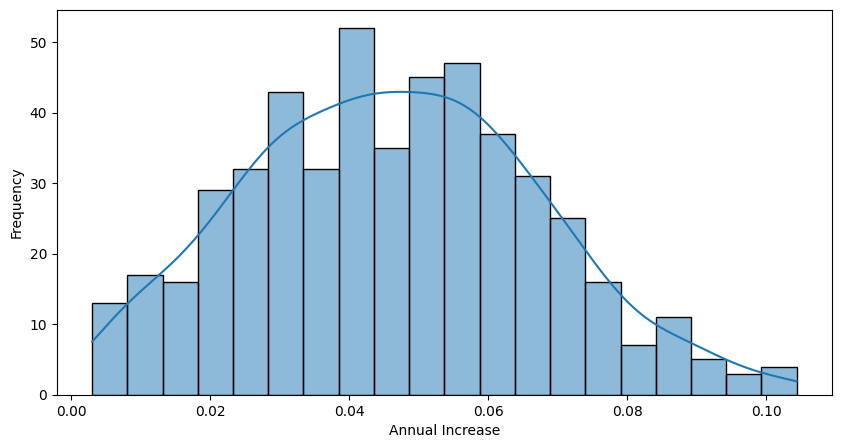

mu = 0.0463, sigma = 0.0209


In [1]:
import numpy as np
import pandas as pd
import pulp as pl
import numpy_financial as npf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
cpi_data = pd.read_csv('Data/electricity price index.csv')

# Filter the data to include years from 1988 onwards
start_year = 1994
end_year = cpi_data['Year'].max()  # Use the maximum year available in the data
cpi_data_filtered = cpi_data[(cpi_data['Year'] >= start_year) & (cpi_data['Year'] <= end_year)].reset_index(drop=True)

# Define the range of starting years for 15-year periods
# Ensure that start_year + 15 does not exceed the available data
years_to_calculate = range(start_year, end_year - 14)

# Initialize a list to store the results
average_increases = []

# Calculate the average yearly increase for each 15-year period
for year in years_to_calculate:
    initial_cpi = cpi_data_filtered.loc[cpi_data_filtered['Year'] == year, 'CPI'].values[0]
    final_cpi = cpi_data_filtered.loc[cpi_data_filtered['Year'] == year + 15, 'CPI'].values[0]
    avg_increase = (final_cpi - initial_cpi) / 15
    average_increases.append({
        'Start Year': year,
        'End Year': year + 15,
        'Initial CPI': round(initial_cpi, 2),
        'Final CPI': round(final_cpi, 2),
        'Average Yearly Increase': round(avg_increase, 2)
    })

# Create a DataFrame from the results
average_increases_df = pd.DataFrame(average_increases)

annual_increase = average_increases_df['Average Yearly Increase']

annual_increase = [x / 100 for x in annual_increase]

# Fit a normal distribution to the data
mu, sigma = stats.norm.fit(annual_increase)

# Generate random samples for the Monte Carlo Simulation using the normal distribution
num_simulations = 500
samples = np.random.normal(loc=mu, scale=sigma, size=num_simulations)

# Use a while loop to ensure that any negative or zero values are regenerated
while np.any(samples <= 0):
    samples[samples <= 0] = np.random.normal(loc=mu, scale=sigma, size=np.sum(samples <= 0))

print(average_increases_df)
print('==========================================================================')
print(f'mu = {mu:.4f}, sigma = {sigma:.4f}')
print('==========================================================================')
print(f'Sample size = {len(samples)}')

plt.figure(figsize=(10, 5))
sns.histplot(samples, kde=True, bins=20)
plt.xlabel('Annual Increase')
plt.ylabel('Frequency')
plt.show()

mus, sigmas = stats.norm.fit(samples)

print(f'mu = {mus:.4f}, sigma = {sigmas:.4f}')

### Import data and technology libraries

In [2]:
# Load energy demand, weather data, price data
tdata = pd.read_csv('Data/EnergyWeatherPrice24_5Y_avg_weather1.csv')
#tdata = pd.read_csv('Data/EnergyWeatherPrice24_5Y_avg_weather2.csv')
#tdata = pd.read_csv('Data/EnergyWeatherPrice24_BestWeather.csv')
#tdata = pd.read_csv('Data/EnergyWeatherPrice24_WorstWeather.csv')

# Load day types count
day_count = pd.read_csv('Data/DayTypeCount.csv',index_col='DayType_i')

# Import battery library and convert into Python library
batt_df = pd.read_csv('Data/battery_library.csv')
batt_lib = batt_df.set_index('type').T.to_dict()

# Import PV library and convert into Python library
pv_df = pd.read_csv('Data/pv_library.csv')
pv_lib = pv_df.set_index('type').T.to_dict()

# Create technology types list to iterate through the library
batt_type = list(batt_lib.keys())
pv_type = list(pv_lib.keys())

### Define simulaiton parameters

In [3]:
# Simulaiton length
years_sim = 15 # Length of simulation in years
timestep_size = 1 # Define timestep resolution in hours

# User defined technology selection
user_sel = 0 # 1: user selects the tech, 0: model selects the tech
pv_sel = 1 # PV type selection, see 'type' column in the library for index
batt_sel = 1 # Battery type selection, see 'type' column in the library for index
pv_ins = 1 # 1: install PV, 0: no PV installed
batt_ins = 1 # 1: install batt, 0: no batt installed

# Results output
csv_out = 0 # 1: print results to new row in existing csv; 0: print results to a blank csv (reset csv output files)

# Grid export
ex_op = 0 # 1: electricity export monetised; 0: electricity export not monetised

# Building parameters
max_ex = 320 # Maximum electricity export (kW)
max_im = 237 # Maximum electricity import (kW)
peak_demand = 208.23 # Building's estimated instantaneous peak electricity demand (kW)
peak_sustain = 3 # Number of hours the building sustains the peak load (kW)
A_roof = 2647 # Total roof surface area (m2)
lamda_roof = 0.6 # Fraction of total roof that can be installed with PV
w_roof = 16 # Roof loading capacity (kg/m2)
battR_vol = 67.7 # Volume of battery room (assume 40-ft container for Hook)
lamda_battR = 0.4 # Fraction of total battery room volume that can be installed with batterys

# Technonology parameters
max_soc_set = 1 # User defined max soc
min_soc_set = 0.4 # User defined min soc
batt_mrgn = 1.2 # Design margin for battery power output, user defined

# Financial parameters
years_fin = 5 # Length of financial analysis in years
disc_rate = 0.1 # Discount rate
present_val = np.array([1 / (1 + disc_rate) ** y for y in range(years_sim+1)])
infl_rate = 0.04 # Inflation rate
infl_val = np.array([(1 + infl_rate) ** y for y in range(years_sim+1)])

### Extend timeseries data to simulaiton length

In [4]:
# Extend the DataFrame to cover simulation length by repeating the data
extended_data = pd.concat([tdata] * years_sim, ignore_index=True)

# Create the year column
rows_per_year = len(extended_data) // years_sim
year_column = [year for year in range(years_sim) for x in range(rows_per_year)]

# Add the year column to the dataframe
extended_data['Year'] = year_column

# Reorder the columns to have 'Year' as the left-most column
cols = ['Year'] + [col for col in extended_data if col != 'Year']
extended_data = extended_data[cols]

# Calculate electricity price increase
CCL_increase = 0.05 # Environmental tarrifs increase per year
DUoS_increase = 0.03 # DUoS cost increase per year
Whl_increase = 0.035 # Wholesale price increase per year

# Get the unique years
unique_years = extended_data['Year'].unique()

# Apply the increase for each year. 
for year in unique_years:
    
    factor_DUoS = (1 + DUoS_increase) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'DUoS export (GBP/kWh)'] *= factor_DUoS
    extended_data.loc[extended_data['Year'] == year, 'DUoS import (GBP/kWh)'] *= factor_DUoS
    
    factor_Whl = (1 + Whl_increase) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'Wholesale (GBP/kWh)'] *= factor_Whl

    factor_CCL = (1 + CCL_increase * 0.9647 / 16) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'Misc (GBP/kWh)'] *= factor_CCL

#extended_data['Import Price (GBP/kWh)'] = extended_data['Wholesale (GBP/kWh)'] + extended_data['DUoS import (GBP/kWh)'] + extended_data['Misc (GBP/kWh)']
#extended_data['Export Price (GBP/kWh)'] = extended_data['Wholesale (GBP/kWh)'] + extended_data['DUoS export (GBP/kWh)']

### Model equipment degradation and replacement

In [5]:
# Initialise dictionaries for equipment state of health
health_pv = {}
health_inv = {}
health_batt = {}

# Initialise dictionaries for number of replacement
rep_pv = {}
rep_inv = {}
rep_batt = {}

# Initialize dictionaries for time counter
year_since_last_rep_pv = {}
year_since_last_rep_inv = {}
year_since_last_rep_batt = {}

for p in pv_type:
    # Initialise time counter
    year_since_last_rep_pv[p] = 0
    year_since_last_rep_inv[p] = 0

for b in batt_type: 
    # Initialise time counter
    year_since_last_rep_batt[b] = 0

for year in range(years_sim):
    
    # Initialise health dictionary
    health_pv[year] = {}
    health_inv[year] = {}
    health_batt[year] = {}

    # Initialise replacement dictionary
    rep_pv[year] = {}
    rep_inv[year] = {}
    rep_batt[year] = {}

    for p in pv_type:
        
        # Initialise replacement value
        rep_pv[year][p] = 0
        rep_inv[year][p] = 0

        if year == 0:
        # Initialise equipment degradation
            health_pv[year][p] = 1
            health_inv[year][p] = 1
        else:
        # Calculate equipment degradation
            health_pv[year][p] = health_pv[year-1][p] - pv_lib[p]['deg_pv']
            health_inv[year][p] = health_inv[year-1][p] - pv_lib[p]['deg_inv']
        
        # Check for PV replacement
        if year_since_last_rep_pv[p] >= pv_lib[p]['life_pv']:
            rep_pv[year][p] = 1
            health_pv[year][p] = 1  # Reset health
            year_since_last_rep_pv[p] = 0 # Reset the counter

        # Check for inverter replacement
        if year_since_last_rep_inv[p] >= pv_lib[p]['life_inv']:
            rep_inv[year][p] = 1
            health_inv[year][p] = 1  # Reset health
            year_since_last_rep_inv[p] = 0 # Reset the counter

        # Increment for time counter
        year_since_last_rep_pv[p] += 1
        year_since_last_rep_inv[p] += 1
        
    for b in batt_type:

        # Initialise replacement value
        rep_batt[year][b] = 0

        if year == 0:
            # Initialise equipment degradation
            health_batt[year][b] = 1
        else:
            # Calculate equipment degradation
            health_batt[year][b] = health_batt[year-1][b] - batt_lib[b]['deg_batt']

        # Check for battery replacement
        if year_since_last_rep_batt[b] >= batt_lib[b]['life_batt']:
            rep_batt[year][b] = 1
            health_batt[year][b] = 1  # Reset health
            year_since_last_rep_batt[b] = 0 # Reset the counter

        # Increment for time counter
        year_since_last_rep_batt[b] += 1 

### Create LP optimisaiton problem and define variables

In [6]:
# Create linear programming problem
model = pl.LpProblem("15-year_NPC_Minimise", pl.LpMinimize)

# Create lists for year, day_type, hour indexes
year_i = list(extended_data['Year'].unique())
day_type_i = list(extended_data['DayType_i'].unique())
hour_i = list(extended_data['Hour'].unique())

# Define continuous variables
N_pv = pl.LpVariable.dicts("N_pv", pv_type, lowBound = 0, cat=pl.LpInteger) # Number of PV modules
E_batt = pl.LpVariable.dicts("E_batt", batt_type, lowBound = 0, cat=pl.LpContinuous) # Battery energy capacity
O_batt = pl.LpVariable.dicts("O_batt", batt_type, lowBound = 0, cat=pl.LpContinuous) # Battery power capacity
E_im = pl.LpVariable.dicts("E_im", (year_i, day_type_i, hour_i), lowBound=0, cat=pl.LpContinuous) # Electricity import
E_ex = pl.LpVariable.dicts("E_ex", (year_i, day_type_i, hour_i), lowBound=0, cat=pl.LpContinuous) # Electricity export
E_batt_c = pl.LpVariable.dicts("E_batt_c", (year_i, day_type_i, hour_i, batt_type), lowBound=0, cat=pl.LpContinuous) # Baterring charging
E_batt_d = pl.LpVariable.dicts("E_batt_d", (year_i, day_type_i, hour_i, batt_type), lowBound=0, cat=pl.LpContinuous) # Battery discharging

# Define binary variables
beta_batt = pl.LpVariable.dicts("beta_batt", batt_type, cat=pl.LpBinary) # Battery selection binary
beta_pv = pl.LpVariable.dicts("beta_pv", pv_type, cat=pl.LpBinary) # PV selection binary
beta_im = pl.LpVariable.dicts("beta_im", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Import exclusivity binary
beta_ex = pl.LpVariable.dicts("beta_ex", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Export exclusivity binary
beta_c = pl.LpVariable.dicts("beta_c", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Battery charging exclusivity binary
beta_d = pl.LpVariable.dicts("beta_d", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Battery discharge exclusivity binary

### Set technology seleciton and design constraints

In [7]:
for p in pv_type:
    # PV type selection
    model += N_pv[p] <= beta_pv[p] * 10e9 * pv_ins

    # Constraint to ensure the number of installed PV panels do not exceed roof size
    model += N_pv[p] <= A_roof * lamda_roof * pl.lpSum(beta_pv[p] * (1 / pv_lib[p]['A_pv']) for p in pv_type)

    # Constraint to ensure total PV weight do not exceed roof loading capacity
    model += N_pv[p] <= A_roof * w_roof * pl.lpSum(beta_pv[p] * (1 / pv_lib[p]['w_pv']) for p in pv_type)

for b in batt_type:
    # Battery type selection
    model += E_batt[b] <= beta_batt[b] * 10e9 * batt_ins # Battery energy capacity
    model += O_batt[b] <= beta_batt[b] * 10e9 * batt_ins # Battery power output

    # Constraint to ensure battery + PCS volume do not exceed battery room volume
    model += pl.lpSum(O_batt[b] * batt_mrgn * (1/batt_lib[b]['vol_pcs']) + E_batt[b] * (1/batt_lib[b]['vol_batt']) for b in batt_type) <= battR_vol * lamda_battR

    # Constraint to ensure that battery power output and max electricity import can meet building's peak demand
    model += pl.lpSum(O_batt[b] for b in batt_type) + max_im >= peak_demand
            
# Constraints to ensure only one technology type is selected
model += pl.lpSum(beta_batt[b] for b in batt_type) == 1
model += pl.lpSum(beta_pv[p] for p in pv_type) == 1

# Constraints for user defined selection
if user_sel == 1:
    model += beta_batt[batt_sel] == user_sel
    model += beta_pv[pv_sel] == user_sel

### Set energy balance and all related components

In [8]:
# Initialise dictionaries for calculation results
E_pv_yt_dict = {}
E_batt_lvl_dict = {}
E_batt_res_dict = {}

# Group DataFrame by year
year_group = extended_data.groupby('Year')

# Iterate over the DataFrame years
for year, year_data in year_group:
    
    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')

    # Initialise dictionaries by year
    E_pv_yt_dict[year] = {}
    E_batt_lvl_dict[year] = {}
    E_batt_res_dict[year] = {}

    # Iterate over the DataFrame day types
    for day, day_data in day_group:
        
        # Initialise dictionaries by year and day type
        E_pv_yt_dict[year][day] = {}
        E_batt_lvl_dict[year][day] = {}
        E_batt_res_dict[year][day] = {}

        # Iterate over the DataFrame hours
        for idx, row in day_data.iterrows():
            
            hour = row['Hour']

            # Calculate PV energy output
            Tref = 25  # Reference temperature (degrees Celsius)

            Tcell_yt = row['Air Temperature (degC)'] + 0.0256 * row['Irradiance (W/m2)'] # Cell temperature (Tcell)

            sum_p = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * health_pv[year][p] * pv_lib[p]['eff_inv'] * health_inv[year][p]
                                                            * (1 + pv_lib[p]['k_pv'] * (Tcell_yt - Tref)) for p in pv_type)
            
            E_pv_yt = row['Irradiance (W/m2)'] / 1000 * sum_p * timestep_size

            # Update residual battery capacity
            E_batt_res = pl.lpSum(E_batt[b] * health_batt[year][b] for b in batt_type)

            # Update battery level
            E_batt_init = E_batt_res * min_soc_set # Initialise battery energy level -> revise to 40%, 45% - 50% 
            if hour == 0:
                E_batt_lvl = E_batt_init + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c']
                                                - E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)
            else:
                E_batt_lvl =  E_batt_lvl_dict[year][day][hour-1] + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c']
                                                - E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)

            # Ensure battery level at each timestep is within SOC limit
            model += E_batt_lvl <= pl.lpSum(E_batt[b] * health_batt[year][b] * batt_lib[b]['max_soc'] for b in batt_type) # Technology max_soc
            model += E_batt_lvl >= pl.lpSum(E_batt[b] * health_batt[year][b] * batt_lib[b]['min_soc'] for b in batt_type) # Technolgy min_soc
            model += E_batt_lvl <= pl.lpSum(E_batt[b] * health_batt[year][b] * max_soc_set for b in batt_type) # User defined max_soc
            model += E_batt_lvl >= pl.lpSum(E_batt[b] * health_batt[year][b] * min_soc_set for b in batt_type) # User defined min_soc

            # Ensure battery level can sustain peak demand for the required duration (user defined)
            model += E_batt_lvl >= (peak_demand - max_im) * peak_sustain

            # Battery total charge/discharge counter
            if hour == 0:
                total_batt_c = pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c'] for b in batt_type)
                total_batt_d = pl.lpSum(E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)
            else:
                total_batt_c = total_batt_c + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c'] for b in batt_type)
                total_batt_d = total_batt_d + pl.lpSum(E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)

            # Constraints for charge/discarge rate
            for b in batt_type:
                # Charge/discharge limit
                model += E_batt_c[year][day][hour][b] <= O_batt[b]
                model += E_batt_d[year][day][hour][b] <= O_batt[b]

                # Battery power output limit
                model += O_batt[b] * batt_mrgn <= batt_lib[b]['max_c'] * E_batt[b]
                model += O_batt[b] * batt_mrgn <= batt_lib[b]['max_d'] * E_batt[b]
                
                # Battery charge/discharge exclusivity constraints
                model += E_batt_c[year][day][hour][b] <= beta_c[year][day][hour] * 10e9
                model += E_batt_d[year][day][hour][b] <= beta_d[year][day][hour] * 10e9
                model += beta_c[year][day][hour] + beta_d[year][day][hour] <= 1
                
                # Battery type selection constraint
                model += E_batt_c[year][day][hour][b] <= beta_batt[b] * 10e9
                model += E_batt_d[year][day][hour][b] <= beta_batt[b] * 10e9

            # Import/export capacity limit
            model += E_im[year][day][hour] <= max_im * beta_im[year][day][hour] * timestep_size
            model += E_ex[year][day][hour] <= max_ex * beta_ex[year][day][hour] * timestep_size
            
            # Import/export exclusivity constraints
            model += beta_im[year][day][hour] + beta_ex[year][day][hour] <= 1

            # Energy balance
            model += E_pv_yt + E_im[year][day][hour] - E_ex[year][day][hour] + pl.lpSum(E_batt_d[year][day][hour][b] - E_batt_c[year][day][hour][b] for b in batt_type) == row['Energy Demand (kWh)']

            # Store PV generation and battery level values
            E_pv_yt_dict[year][day][hour] = E_pv_yt
            E_batt_lvl_dict[year][day][hour] = E_batt_lvl
            E_batt_res_dict[year][day][hour] = E_batt_res

        # Add the constraint to ensure battery net energy change is zero over the day
        model += (total_batt_c - total_batt_d == 0)

### Set objective funciton (except for operating cost)

In [9]:
# Define capital cost
Cbatt = pl.lpSum(E_batt[b] * batt_lib[b]['PbattC'] for b in batt_type) # Energy storage cost
Cpv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvC'] for p in pv_type) # PV module cost
Cinv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvINV'] for p in pv_type) # PV inverter cost
Cpcs = pl.lpSum(O_batt[b] * batt_lib[b]['PpcsC'] for b in batt_type) # Battery PCS cost
CBOSpv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvEBOS'] + N_pv[p] * pv_lib[p]['PpvSBOS'] 
                  * pv_lib[p]['A_pv'] for p in pv_type) # PV BOS costs
CBOSbatt = pl.lpSum(O_batt[b] * batt_lib[b]['PbattBOS'] for b in batt_type) # Battery BOS costs
CInspv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvIns'] for p in pv_type) # PV installation cost
CInsbatt = pl.lpSum(E_batt[b] * batt_lib[b]['PbattIns'] for b in batt_type) # Battery installation cost
C_CAP_pv = (Cpv + Cinv + CBOSpv + CInspv)
C_CAP_batt = (Cbatt + Cpcs + CBOSbatt + CInsbatt)
C_CAP = (C_CAP_pv + C_CAP_batt) # Total capital cost

# Define maintenance cost
CpvM = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvM'] for p in pv_type)
CbattM = pl.lpSum(O_batt[b] * batt_mrgn * batt_lib[b]['PbattM'] for b in batt_type)
C_My = [(CpvM + CbattM) * infl_val[year] * present_val[year] for year in range(years_sim)]  # Yearly maintenance cost
C_M = pl.lpSum([C_My[year] for year in range(years_sim)]) # Total maintenance cost

# Define replacement cost
# Initialise costs dictionaries
CbattR = {}
CpvR = {}
CinvR = {}

# Iterate over simulaiton years
for year in range(years_sim):
    CbattR[year] = pl.lpSum(E_batt[b] * rep_batt[year][b] * batt_lib[b]['PbattR'] for b in batt_type) * infl_val[year] * present_val[year] # Battery replacement cost
    CpvR[year] = pl.lpSum(N_pv[p] * rep_pv[year][p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvR'] for p in pv_type) * infl_val[year] * present_val[year] # PV replacement cost
    CinvR[year] = pl.lpSum(N_pv[p] * rep_inv[year][p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PinvR'] for p in pv_type) * infl_val[year] * present_val[year] # Inverter replacement cost

# Calculate total replacement costs
C_REP = pl.lpSum((CbattR[year] + CpvR[year] + CinvR[year]) for year in range(years_sim)) # Total replacement cost

### Define function to perform MCS

In [10]:
def run_MCS(annual_increase, prob):

    increase_val = np.array([(1 + annual_increase) ** y for y in range(years_sim+1)])

    #Define operating cost
    # Initialise dictionary
    Op_cost = {} 
    Op_cost_bau = {}

    for year, year_data in year_group:
        
        # Group data in year_data by day type
        day_group = year_data.groupby('DayType_i')
        Op_cost[year] = {}
        Op_cost_bau[year] = 0.0

        for day, day_data in day_group:

            for idx, row in day_data.iterrows():
                
                hour = row['Hour']

                # Calculate yearly opearting cost
                import_price = row['Import Price (GBP/kWh)'] * increase_val[year] # wholesale price + DUoS import + Misc.
                export_price = row['Export Price (GBP/kWh)'] * ex_op * increase_val[year] # wholesale price + DUoS export 
                Op_cost[year] = Op_cost[year] + (E_im[year][day][hour] * import_price - E_ex[year][day][hour] * export_price) * day_count.loc[day, 'DayCount'] * present_val[year]

                # Calculate BaU cost
                Op_cost_bau[year] = Op_cost_bau[year] + row['Energy Demand (kWh)'] * import_price * day_count.loc[day, 'DayCount'] * present_val[year]

    C_O = pl.lpSum([Op_cost[year] for year in range(years_sim)]) # Total operating cost

    # Define the objective function
    prob += C_CAP + C_O + C_M + C_REP, "Total Cost"

    solver = pl.GUROBI()
    prob.solve(solver)

    # Calculate results

    # Objective function value with battery power output design margin
    C_CAP_batt_act = Cbatt + Cpcs * batt_mrgn + CBOSbatt * batt_mrgn + CInsbatt
    C_CAP_act = C_CAP_batt_act + C_CAP_pv
    OF_act = C_CAP_act + C_O + C_M + C_REP
    
    # Total BaU Costs
    C_BAU = pl.lpSum([Op_cost_bau[year] for year in range(years_sim)])

    # Total Savings
    SAVE_act = C_BAU - OF_act
    SAVE = C_BAU - pl.value(prob.objective)

    # Identify the selected PV type
    selected_pv_type = [p for p in pv_type if pl.value(N_pv[p]) > 0]

    # Identify the selected battery type
    selected_batt_type = [b for b in batt_type if pl.value(E_batt[b]) > 0]

    #Calculate Financial Parameters
    #Initialise dictionary
    cf_npv = {}
    cf_irr = {}
    for year in range(years_sim + 1):
        if year == 0:
            cf_npv[year] = - C_CAP_act
            cf_irr[year] = pl.value(( - C_CAP_act) / present_val[year])
        else:
            cf_npv[year] = ((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1]) / present_val[year - 1] * present_val[year]
            cf_irr[year] = pl.value(((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1]) / present_val[year - 1])

    NPV = pl.lpSum(cf_npv[year] for year in range(years_fin + 1))
    IRR = npf.irr([cf_irr[year] for year in range(years_fin + 1)])
    ROI = pl.value(NPV) / pl.value(C_CAP_act)

    # Calculate Payback Period
    payback_period = None # Initialise payback period
    cumulative_cash_flow = 0 # Initialise cumulative cashflow
    cash_flows = []
    # Iterate through each year's cash flow to calculate the cumulative cash flow
    for year in range(years_sim + 1):
        # Convert cf_npv[year] to its numeric value
        year_cash_flow = pl.value(cf_npv[year])
        cumulative_cash_flow += year_cash_flow  # Update the cumulative cash flow
        cash_flows.append(cumulative_cash_flow)
        if cumulative_cash_flow >= 0:  # Check if the cumulative cash flow has recovered the initial investment
            # Calculate the exact payback period including fractional years
            payback_period = pl.value((year - 1) - (cumulative_cash_flow - year_cash_flow) / year_cash_flow)
            break

    # Extrapolate if payback period is beyond the simulation period
    if payback_period is None:
        # Number of years to consider for extrapolation
        extrapolate_years = years_sim + 1
        if len(cash_flows) >= extrapolate_years:
            # Calculate the slope (average annual growth) of cumulative cash flow for the last few years
            x = np.arange(years_sim + 1 - extrapolate_years, years_sim + 1)
            y = np.array(cash_flows[-extrapolate_years:])
            slope, intercept = np.polyfit(x, y, 1)
                
            # Calculate the remaining amount needed to reach payback
            remaining_cash_flow = -cumulative_cash_flow
                
            # Estimate additional years required to reach payback
            additional_years = remaining_cash_flow / slope
                
            # Estimate payback period
            payback_period = years_sim + additional_years
        else:
            payback_period = -1
   
    resultsMCS = {
        'Annual Increase': annual_increase,
        'BaU Costs (GBP)': pl.value(C_BAU),
        'Objective Value act (GBP)': pl.value(OF_act),
        'Objective Value (GBP)': pl.value(prob.objective),
        'Operating Cost (GBP)': pl.value(C_O),
        'Capital Cost (GBP)': pl.value(C_CAP_act),
        'PV Capital Cost (GBP)': pl.value(C_CAP_pv),
        'Battery Capital Cost (GBP)': pl.value(C_CAP_batt_act),
        'Maintenance Cost (GBP)': pl.value(C_M),
        'Total Savings act (GBP)': pl.value(SAVE_act),
        'Total Savings (GBP)': pl.value(SAVE),
        'PV Type': [pv_lib[p]['name'] for p in selected_pv_type],
        'Number of PV modules': pl.value(pl.lpSum(N_pv[p] for p in pv_type)),
        'PV capacity (kW)': pl.value(pl.lpSum(N_pv[p] * pv_lib[p]['eff_pv'] * pv_lib[p]['A_pv'] for p in pv_type)),
        'Battery Type': [batt_lib[b]['name'] for b in selected_batt_type],
        'Battery capacity (kWh)': pl.value(pl.lpSum(E_batt[b] for b in batt_type)),
        'Battery power output (kW)': pl.value(pl.lpSum(O_batt[b] * batt_mrgn for b in batt_type)),
        'NPV (GBP)': pl.value(NPV),
        'IRR': pl.value(IRR),
        'ROI': pl.value(ROI),
        'Payback period (years)': payback_period,
    }

    return resultsMCS

### Perform MCS

In [11]:

results_df = pd.DataFrame(columns=['Annual Increase', 'BaU Costs (GBP)', 'Objective Value act (GBP)', 'Objective Value (GBP)', 'Operating Cost (GBP)', 'Capital Cost (GBP)', 
                                   'PV Capital Cost (GBP)', 'Battery Capital Cost (GBP)', 'Maintenance Cost (GBP)', 'Total Savings act (GBP)', 'Total Savings (GBP)',
                                   'PV Type', 'Number of PV modules', 'PV capacity (kW)', 
                                   'Battery Type', 'Battery capacity (kWh)', 'Battery power output (kW)',
                                   'NPV (GBP)', 'IRR', 'ROI', 'Payback period (years)'])

for rate in samples:
    result = run_MCS(rate, model)
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 389190 rows, 120980 columns and 5307780 nonzeros
Model fingerprint: 0x5b530d5e
Variable types: 86408 continuous, 34572 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-09, 1e+10]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2433318.5862
Presolve removed 130135 rows and 17280 columns (presolve time = 5s) ...


### Save results to CSV

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('Results/MCS.csv', index=False)